In [117]:
import numpy as np
import scipy
from scipy import linalg
from matplotlib import pyplot as plt
import functools as ftls

X = np.array([[0.0, 1.0], [1.0, 0.0]])
Z = np.array([[1.0, 0.0], [0.0, -1.0]])
I = np.array([[1.0, 0.0], [0.0, 1.0]])

qubits = 3

H_p = np.zeros([2**qubits,2**qubits], dtype='complex')
for k in range(qubits):
    H_p = (-1/2) * (2*np.kron(I,np.kron(I, I)) - 
                    np.kron(Z, np.kron(Z, I)) - 
                    np.kron(I, np.kron(Z, I)))
print(H_p)

H_d = np.zeros([2**qubits]*2, dtype = Z.dtype)
for j in range(qubits):
    H_d += 1.0 * ftls.reduce(np.kron, [np.eye(2**j), X, np.eye(2**(qubits-j-1))])
#H_d = np.kron(X, np.kron(I, I)) + np.kron(I, np.kron(X, I)) + np.kron(I, np.kron(I, X))
print(H_d)

eigenValues_p, eigenVectors_p = np.linalg.eig(H_p)
idx_p = np.argsort(eigenValues_p)
eigenValues_p = eigenValues_p[idx_p]
eigenVectors_p = eigenVectors_p[:, idx_p]

eigenValues, eigenVectors = np.linalg.eig(H_d)
idx = np.argsort(eigenValues)
eigenValues = eigenValues[idx]
eigenVectors = eigenVectors[:, idx]

psi_0 = eigenVectors[:, 0] #Initial psi

dt = 0.2 #Time step
U_p = linalg.expm(-1j*H_p*dt) #Unitary for Problem
comm = 1j*(H_d @ H_p - H_p @ H_d) #Commutator for Hamiltonians
n_steps = 100 #Number of steps
beta = [0] #Empty array to store betas with the 0th element being 0
success_probability = []
cost_function = [float(np.real(np.conj(np.transpose(psi_0)) @ H_p @ psi_0))]#

U_d = linalg.expm(-1j*beta[0]*H_d*dt) #Unitary for Driver
psi = U_d @ U_p @ psi_0 #Create psi with initial psi
A = float(np.real(np.conj(np.transpose(psi)) @ comm @ psi))
beta.append(-A) #Add -A to beta array
cost_function.append(float(np.real(np.conj(np.transpose(psi)) @ H_p @ psi)))#

psi_list = []
phi_list = []

i = 1 #Already set the first layer, this is for each layer after
while i < n_steps:
    U_d = linalg.expm(-1j*beta[i]*H_d*dt) #Create Unitary Driver
    psi = U_d @ U_p @ psi #Create psi
    A = float((np.real(np.conj(np.transpose(psi)) @ comm @ psi)))#Estimate A
    beta.append(-A) #Add -A to beta array
    cost_function.append(float(np.real(np.conj(np.transpose(psi)) @ H_p @ psi)))#
    psi_list.append(psi)
    
    k = 0
    phi = 0
    for k in range(len(eigenValues_p)):
        if eigenValues_p[0] == eigenValues_p[k]:
            phi =+ phi + ((np.absolute(np.vdot(eigenVectors_p[:,k], psi)))**2)
    phi_list.append(phi)
    '''phi = ((np.absolute(np.vdot(eigenVectors_p[:,0], psi)))**2) + ((np.absolute(np.vdot(eigenVectors_p[:,1], psi)))**2)
    psi_list.append(psi)
    phi_list.append(phi)'''
    i = i+1 #increment i

[[-0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -0.]
 [-0. -0. -2. -0. -0. -0. -0. -0.]
 [-0. -0. -0. -2. -0. -0. -0. -0.]
 [-0. -0. -0. -0. -1. -0. -0. -0.]
 [-0. -0. -0. -0. -0. -1. -0. -0.]
 [-0. -0. -0. -0. -0. -0. -1. -0.]
 [-0. -0. -0. -0. -0. -0. -0. -1.]]
[[0. 1. 1. 0. 1. 0. 0. 0.]
 [1. 0. 0. 1. 0. 1. 0. 0.]
 [1. 0. 0. 1. 0. 0. 1. 0.]
 [0. 1. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 1. 0.]
 [0. 1. 0. 0. 1. 0. 0. 1.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0. 1. 1. 0.]]


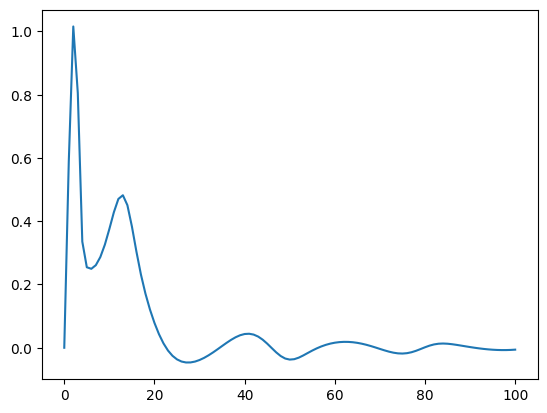

In [118]:
plt.plot(beta)
plt.show()

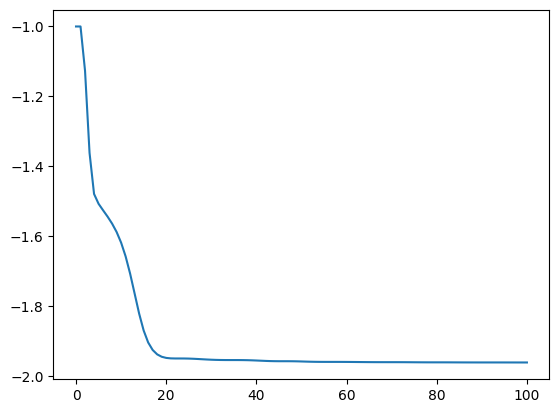

In [119]:
plt.plot(cost_function)
plt.show()

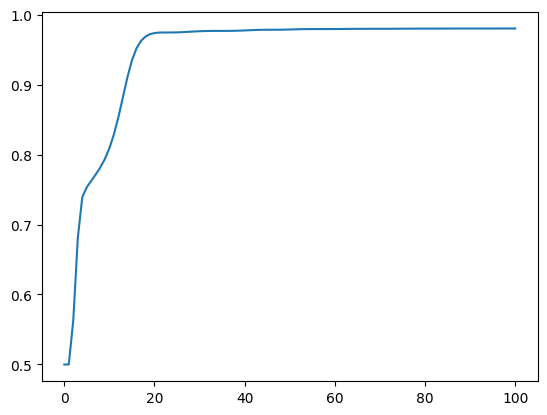

In [120]:
approximation_ratio = cost_function/eigenValues_p[0]
plt.plot(approximation_ratio)
plt.show()

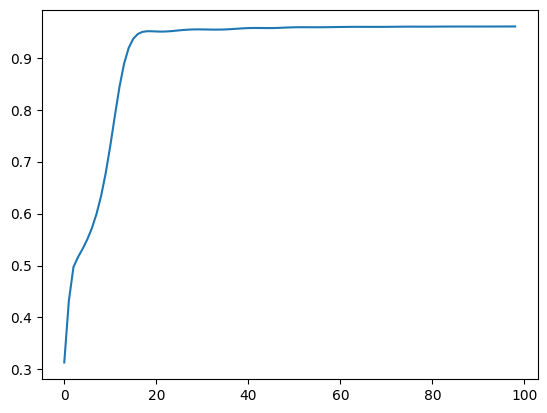

In [121]:
plt.plot(phi_list)
plt.show()